In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Get data

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

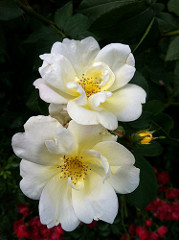

In [4]:
# check a sample image
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# Create dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180

# use keras.preprocessing to load images into dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width), # resizes the images to img_height and img_width, can also use a keras resizing layer
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
# dataset has a class_names attribute
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


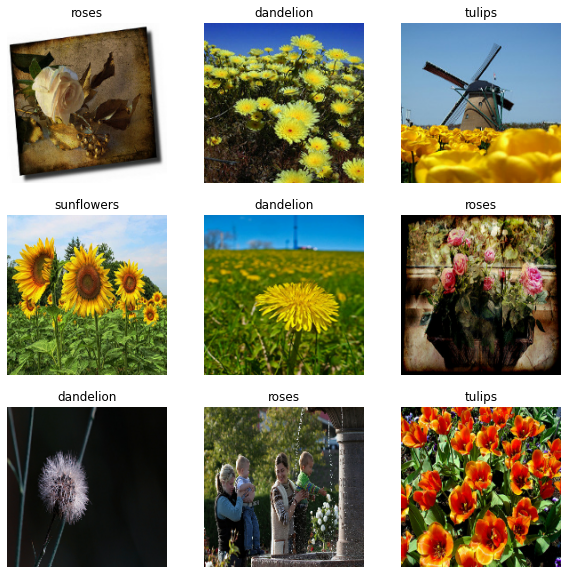

In [8]:
# visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# configure dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build model

In [11]:
num_classes = 5

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [14]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 5s 50ms/step - loss: 1.3840 - accuracy: 0.4244 - val_loss: 1.1378 - val_accuracy: 0.5177
Epoch 2/10
92/92 [==============================] - 3s 34ms/step - loss: 1.0188 - accuracy: 0.5923 - val_loss: 1.0506 - val_accuracy: 0.5858
Epoch 3/10
92/92 [==============================] - 3s 34ms/step - loss: 0.8712 - accuracy: 0.6659 - val_loss: 0.8914 - val_accuracy: 0.6390
Epoch 4/10
92/92 [==============================] - 3s 34ms/step - loss: 0.6543 - accuracy: 0.7483 - val_loss: 0.9858 - val_accuracy: 0.6131
Epoch 5/10
92/92 [==============================] - 3s 34ms/step - loss: 0.4429 - accuracy: 0.8447 - val_loss: 1.0815 - val_accuracy: 0.6267
Epoch 6/10
92/92 [==============================] - 3s 34ms/step - loss: 0.2930 - accuracy: 0.9022 - val_loss: 1.1776 - val_accuracy: 0.6335
Epoch 7/10
92/92 [==============================] - 3s 34ms/step - loss: 0.1795 - accuracy: 0.9404 - val_loss: 1.2681 - val_accuracy: 0.6580
Epoch 8/10
92

# Visualization

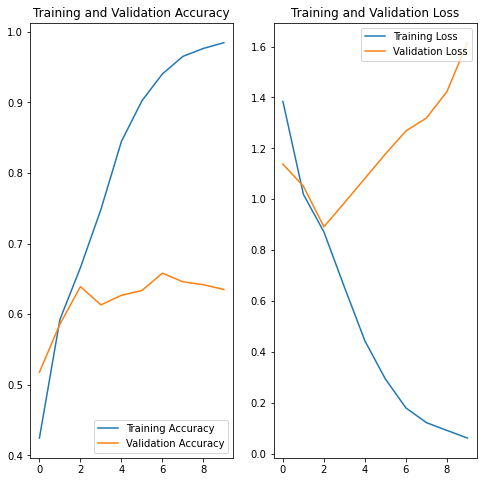

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

In [16]:
# create data augmentation layers
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

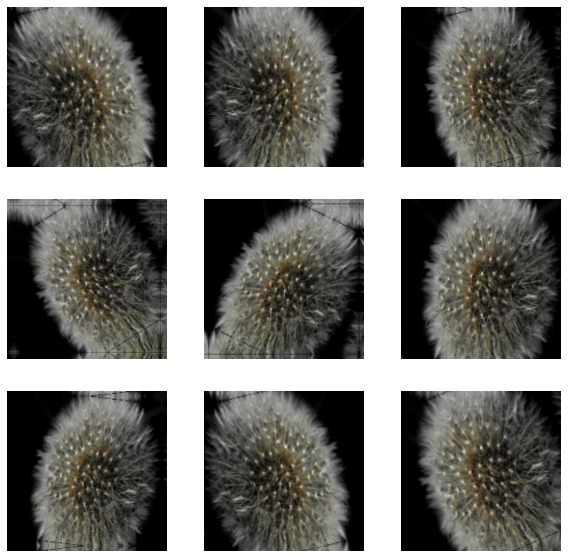

In [17]:
# check some augmented samples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

# Dropout

In [19]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Model

In [20]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [21]:
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
92/92 [==============================] - 4s 40ms/step - loss: 1.3264 - accuracy: 0.4346 - val_loss: 1.1615 - val_accuracy: 0.5041
Epoch 2/15
92/92 [==============================] - 4s 38ms/step - loss: 1.0437 - accuracy: 0.5954 - val_loss: 1.0325 - val_accuracy: 0.5872
Epoch 3/15
92/92 [==============================] - 4s 38ms/step - loss: 0.9449 - accuracy: 0.6362 - val_loss: 0.9191 - val_accuracy: 0.6540
Epoch 4/15
92/92 [==============================] - 4s 38ms/step - loss: 0.8679 - accuracy: 0.6764 - val_loss: 0.8472 - val_accuracy: 0.6662
Epoch 5/15
92/92 [==============================] - 4s 38ms/step - loss: 0.8159 - accuracy: 0.6941 - val_loss: 0.8035 - val_accuracy: 0.6853
Epoch 6/15
92/92 [==============================] - 4s 38ms/step - loss: 0.7811 - accuracy: 0.7071 - val_loss: 0.8389 - val_accuracy: 0.6540
Epoch 7/15
92/92 [==============================] - 4s 38ms/step - loss: 0.7394 - accuracy: 0.7265 - val_loss: 0.7552 - val_accuracy: 0.7016
Epoch 8/15
92

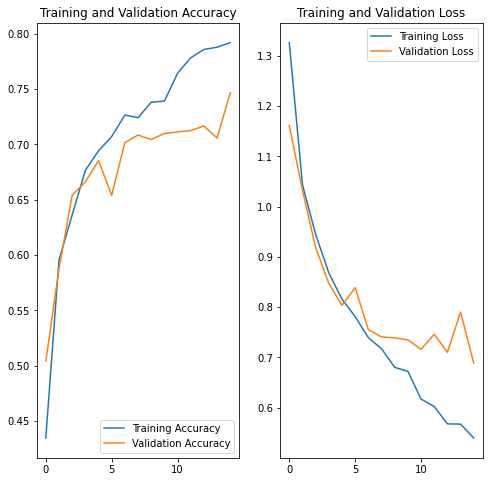

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

In [23]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 1us/step
This image most likely belongs to sunflowers with a 96.14 percent confidence.
